In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import pandas as pd
from tqdm import tqdm

In [0]:
def load(csv_path):
    data=[]
    labels=[]
    
    rows = open(csv_path).read().strip().split("\n")[1:]
    random.shuffle(rows)
    
    for i , row in tqdm(enumerate(rows)):
        
        (label,imagePath) = row.strip().split(",")[-2:]
        labels.append(int(label))
        #imagePath = os.path.sep.join(imagePath)
        image = io.imread(imagePath)
        image = transform.resize(image,(32,32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1) #CHLAE
        
        data.append(image)
    labels = np.array(labels)
    data = np.array(data)    
    
    return (data,labels)


In [25]:
label_names = open('signnames.csv').read().strip().split(",")[1:]
label_names = [l.split(",")[0] for l in label_names]
label_names

['SignName\n0',
 'Speed limit (20km/h)\n1',
 'Speed limit (30km/h)\n2',
 'Speed limit (50km/h)\n3',
 'Speed limit (60km/h)\n4',
 'Speed limit (70km/h)\n5',
 'Speed limit (80km/h)\n6',
 'End of speed limit (80km/h)\n7',
 'Speed limit (100km/h)\n8',
 'Speed limit (120km/h)\n9',
 'No passing\n10',
 'No passing for vehicles over 3.5 metric tons\n11',
 'Right-of-way at the next intersection\n12',
 'Priority road\n13',
 'Yield\n14',
 'Stop\n15',
 'No vehicles\n16',
 'Vehicles over 3.5 metric tons prohibited\n17',
 'No entry\n18',
 'General caution\n19',
 'Dangerous curve to the left\n20',
 'Dangerous curve to the right\n21',
 'Double curve\n22',
 'Bumpy road\n23',
 'Slippery road\n24',
 'Road narrows on the right\n25',
 'Road work\n26',
 'Traffic signals\n27',
 'Pedestrians\n28',
 'Children crossing\n29',
 'Bicycles crossing\n30',
 'Beware of ice/snow\n31',
 'Wild animals crossing\n32',
 'End of all speed and passing limits\n33',
 'Turn right ahead\n34',
 'Turn left ahead\n35',
 'Ahead only\

In [5]:
train_path = 'Train.csv'
test_path = 'Test.csv'


# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

trainX,trainY = load(train_path)

39209it [13:15, 49.26it/s]


In [9]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4695493038377327628, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5461905013131497531
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8744643665320766056
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7470045594
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2627809937896014017
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [6]:
testX,testY = load(test_path)

12630it [04:20, 48.52it/s]


In [0]:
trainX = trainX / 255
testX = testX / 255

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [9]:
model = Sequential()
inputShape = (32, 32, 3)
chanDim = -1
# CONV => RELU => BN => POOL
model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

		# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

		# softmax classifier
model.add(Dense(numLabels))
model.add(Activation("softmax"))
        

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [0]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

In [16]:
model.fit_generator(
	aug.flow(trainX, trainY, batch_size=64),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0],
	epochs=10,
	class_weight=classWeight)

Epoch 1/10
39209/39209 [==============================] - 1407s 36ms/step - loss: 0.1133 - acc: 0.9647 - val_loss: 0.1148 - val_acc: 0.9648
Epoch 2/10
39209/39209 [==============================] - 1378s 35ms/step - loss: 0.0535 - acc: 0.9837 - val_loss: 0.6603 - val_acc: 0.8404
Epoch 3/10
39209/39209 [==============================] - 1382s 35ms/step - loss: 0.0395 - acc: 0.9879 - val_loss: 0.5938 - val_acc: 0.8591
Epoch 4/10
39209/39209 [==============================] - 1379s 35ms/step - loss: 0.0330 - acc: 0.9900 - val_loss: 1.3200 - val_acc: 0.7562
Epoch 5/10
39209/39209 [==============================] - 1381s 35ms/step - loss: 0.0288 - acc: 0.9913 - val_loss: 0.4482 - val_acc: 0.9034
Epoch 6/10
39209/39209 [==============================] - 1376s 35ms/step - loss: 0.0259 - acc: 0.9921 - val_loss: 7.9615 - val_acc: 0.2053
Epoch 7/10
39209/39209 [==============================] - 1387s 35ms/step - loss: 0.0235 - acc: 0.9928 - val_loss: 1.1751 - val_acc: 0.7959
Epoch 8/10
39209/392

In [0]:
model.save('traffic-sign-classification.h5')

In [0]:
from imutils import paths

In [0]:
imgPaths = list(paths.list_images("Test"))
random.shuffle(imgPaths)

In [0]:
imgPaths = imgPaths[:5]

In [0]:
import cv2
import imutils
from google.colab.patches import cv2_imshow

preds :  [[1.9766418e-07 2.1853783e-05 9.9993873e-01 3.1658772e-06 3.1919583e-06
  5.3722474e-06 1.6294289e-11 5.9551639e-09 1.3594403e-08 1.0207462e-08
  5.1174633e-09 1.3183324e-10 2.9559615e-11 9.0941249e-10 3.1496086e-10
  1.7696261e-11 4.0271218e-13 3.8188484e-14 1.0630954e-09 1.8568203e-08
  7.3333334e-10 4.1147163e-07 5.7900173e-12 1.7125802e-05 1.8902366e-10
  8.3226075e-09 1.1878788e-10 5.3883098e-09 1.2797558e-08 6.5961676e-09
  2.3528504e-10 6.3220895e-10 3.5934515e-12 1.4739785e-09 4.2181728e-10
  1.5466066e-08 4.9362985e-09 5.1250169e-08 5.8492027e-08 4.6185493e-11
  9.5654741e-06 2.8922797e-09 1.9131811e-11]]
J :  2
label :  Speed limit (30km/h)
2


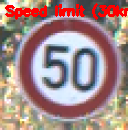

preds :  [[2.7440379e-09 1.1988546e-05 8.4304092e-03 9.9089348e-01 1.6229142e-08
  6.5853901e-04 1.8920522e-08 2.4467687e-07 2.3001625e-09 9.2689874e-08
  2.2254101e-08 6.5854175e-09 2.3471109e-11 1.5530703e-09 1.8898800e-09
  1.7728908e-09 2.4757840e-10 9.4523727e-13 1.6470729e-08 4.0679321e-11
  7.7755926e-09 5.0043818e-09 2.5922138e-11 1.3179668e-07 5.4459640e-12
  8.0070645e-10 1.6968511e-10 2.3558009e-09 2.3785442e-06 2.2552003e-07
  3.4961349e-09 1.3245088e-11 1.2952401e-09 3.5448062e-07 1.2695672e-10
  7.8914146e-09 1.8368575e-06 8.8822205e-10 9.1713108e-09 1.3532743e-09
  2.6129061e-07 1.2823881e-10 4.8347482e-09]]
J :  3
label :  Speed limit (50km/h)
3


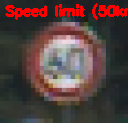

preds :  [[6.84479487e-11 2.66894351e-09 9.67904512e-09 1.49338135e-07
  2.70932556e-08 1.38377496e-08 1.22901715e-11 1.24819941e-08
  2.14551354e-09 1.60822509e-07 1.99949266e-08 4.35198277e-09
  2.79137402e-09 9.99997854e-01 2.66329664e-07 1.33204333e-06
  2.92640760e-12 4.55862736e-10 3.62987223e-08 5.53632140e-11
  3.30094396e-10 1.44017975e-09 7.57531260e-11 1.89450289e-10
  3.59285496e-12 1.13140132e-07 8.39111058e-10 2.34819220e-10
  1.53838418e-11 8.58898563e-10 1.17743419e-11 7.74851350e-10
  1.72770900e-08 1.61959353e-08 1.76194881e-09 1.16840382e-09
  3.68891739e-09 2.93593990e-12 5.70847458e-09 7.81915255e-10
  3.63933800e-10 1.76765436e-09 1.78897541e-09]]
J :  13
label :  Priority road
13


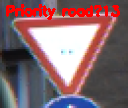

preds :  [[3.45995654e-09 2.31383339e-07 1.10359979e-08 2.65332667e-09
  1.66551928e-07 8.32247937e-10 6.23961216e-10 3.46942848e-08
  1.82498427e-09 1.33655533e-07 9.33945588e-10 7.32445216e-08
  1.32723665e-06 9.99996305e-01 3.49762502e-07 3.03557130e-07
  8.38168771e-11 1.80085902e-09 4.66523232e-07 2.55305199e-09
  3.16114268e-09 2.32625674e-09 1.02480316e-10 2.72053491e-10
  2.44290338e-10 1.51679131e-08 1.48436130e-09 8.71066164e-10
  9.26063948e-11 6.88959612e-10 7.05918874e-12 8.12803047e-10
  1.00366535e-07 2.31981581e-08 4.88202945e-09 3.94604136e-08
  1.15049396e-07 4.69368377e-10 6.48523226e-08 3.73167675e-09
  8.26862703e-08 1.69646341e-07 3.59385055e-08]]
J :  13
label :  Priority road
13


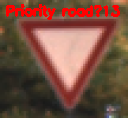

preds :  [[1.22968597e-11 3.21467752e-07 2.49423437e-09 7.07062764e-09
  2.48883367e-07 1.99297617e-07 1.17613506e-11 9.99996424e-01
  2.65206336e-06 3.70831033e-10 1.01197578e-10 2.71809214e-10
  2.15791916e-11 2.93368418e-09 1.22139365e-09 3.08913037e-08
  3.08402304e-10 4.33139939e-12 2.23179073e-13 1.36994555e-13
  7.55503906e-12 1.92399807e-12 7.99713418e-14 1.13821806e-14
  9.82828402e-13 1.12354115e-12 2.23994041e-13 1.01370952e-12
  1.40177561e-12 9.81550778e-13 7.42147455e-11 3.73197046e-12
  2.17039941e-13 1.66865224e-08 2.94921466e-12 2.84317058e-12
  5.76572297e-11 3.56036950e-13 8.94023258e-11 1.22786614e-09
  9.04535388e-12 3.10061260e-15 1.48219645e-10]]
J :  7
label :  End of speed limit (80km/h)
7


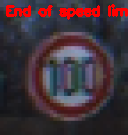

In [37]:
for (i,imgPath) in enumerate(imgPaths):
    image = io.imread(imgPath)
    image = transform.resize(image,(32,32))
    image = exposure.equalize_adapthist(image,clip_limit=0.1)

    image = image.astype("float32") / 255.0
    image = np.expand_dims(image,axis=0)

    preds = model.predict(image)
    print("preds : ",preds)
    j = preds.argmax(axis=1)[0]
    print("J : ",j)
    label = label_names[j]
    print("label : ",label)

    image = cv2.imread(imgPath)
    image = imutils.resize(image,width=128)
    cv2.putText(image,label,(5,15),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0,0,255),2)
    cv2_imshow(image)